# Agentic RAG with DeepSeek-R1 using LangGraph and Together AI

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/Tools_and_Integrations/Agent_Frameworks/LangGraph/Agentic_RAG_LangGraph.ipynb)

<img src="../../../images/langgraph.png" width="700">



This notebook demonstrates how to build an advanced Retrieval-Augmented Generation (RAG) system using LangGraph, a framework for building composable and stateful agent workflows. 

Unlike traditional RAG systems that simply retrieve context and generate an answer, an agentic RAG system can:
- Determine when to search for information
- Decide what to search for
- Evaluate if retrieved information is sufficient
- Make multiple retrieval attempts if needed
- Synthesize information from multiple sources

We'll build a complete agent that can answer questions by intelligently searching and reasoning over a collection of ML blog posts from Lilian Weng.

Adapted from [source](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/).

## Environment Setup

First, we'll import the necessary libraries and set up our environment. We'll use:
- LangGraph for creating our agent framework
- LangChain for components like document retrieval
- Together AI for language models and embeddings
- Chroma for vector storage

In [1]:
%%capture --no-stderr
%pip install -qU langchain-community tiktoken langchain-together together langchainhub chromadb langchain langgraph langchain-text-splitters beautifulsoup4

In [3]:
# Import required libraries for document loading, vector storage, and language models
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_together import ChatTogether

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_together import TogetherEmbeddings

# List of blog posts we'll use as our knowledge base
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Data Loading and Preparation

We'll start by loading blog posts from the web, splitting them into smaller chunks, and creating embeddings to store in our vector database. This process creates the knowledge base our agent will search through.

In [ ]:
# Load documents from web URLs and chunk them into smaller pieces
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

## Vector Database Setup

Now we'll create a vector database using the processed documents. This will allow our agent to perform semantic searches to find relevant information when answering questions.

In [5]:
import os

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=TogetherEmbeddings(model="togethercomputer/m2-bert-80M-2k-retrieval", # long context embedding model
                                 api_key=os.getenv("TOGETHER_API_KEY")),
)
retriever = vectorstore.as_retriever()

In [7]:
# example search from vectorDB
query = "How do I jailbreak a LLM?"
docs = vectorstore.similarity_search(query, k=3)
for i in [docs[j].page_content+'\n\n' for j in range(len(docs))]:
    print(i)
    print('-'*100)

[25] www.jailbreakchat.com
[26] WitchBOT. “You can use GPT-4 to create prompt injections against GPT-4” Apr 2023.


----------------------------------------------------------------------------------------------------
Jailbreak Prompting#
Jailbreak prompts adversarially trigger LLMs to output harmful content that should have been mitigated. Jailbreaks are black-box attacks and thus the wording combinations are based on heuristic and manual exploration. Wei et al. (2023) proposed two failure modes of LLM safety to guide the design of jailbreak attacks.


----------------------------------------------------------------------------------------------------
[19] Xie et al. “Defending ChatGPT against Jailbreak Attack via Self-Reminder.” Research Square (2023)
[20] Jones et al. “Automatically Auditing Large Language Models via Discrete Optimization.” arXiv preprint arXiv:2303.04381 (2023)


----------------------------------------------------------------------------------------------------


In [8]:
from langchain.tools.retriever import create_retriever_tool

# Create a tool for the retriever for the agent
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

## Building the Agentic RAG System

We'll now create our agent using LangGraph. Our agent will use a multi-step workflow:

1. **Planning**: Determine if external information is needed
2. **Retrieval**: Search for relevant documents 
3. **Evaluation**: Determine if the retrieved information is sufficient
4. **Generation**: Create a comprehensive answer
5. **Reflection**: Improve the answer if necessary

This stateful graph allows for multiple iterations through the retrieval and evaluation steps, unlike a simple chain.

In [9]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [10]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

# This is the evaluation step
# It determines whether the retrieved documents are relevant to the question.
# If the documents are relevant, the agent will generate an answer.
# If the documents are not relevant, the agent will rewrite the question and try again.
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatTogether(api_key=os.getenv("TOGETHER_API_KEY"), model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",temperature=0,streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    
    model = ChatTogether(api_key=os.getenv("TOGETHER_API_KEY"), model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",temperature=0, streaming=True)
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatTogether(api_key=os.getenv("TOGETHER_API_KEY"), model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo", temperature=0, streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatTogether(api_key=os.getenv("TOGETHER_API_KEY"), model="deepseek-ai/DeepSeek-R1", temperature=0.6,streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


/Users/zain/Documents/Projects/cookbook_fork/together-cookbook/.conda/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


## Visualizing the Agentic Workflow 

Here we can generate the overall workflow that the agent can take for any given query/prompt.

In [11]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant

# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

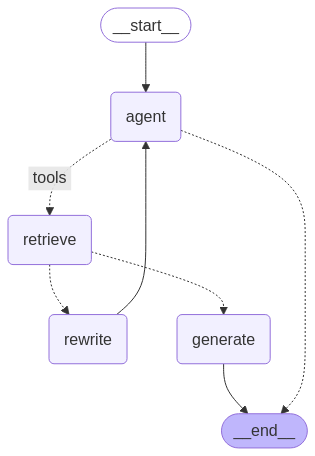

In [10]:
from IPython.display import Image, display


display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


## Testing the Agent

Let's test our agent with some questions about machine learning concepts covered in the blog posts. We'll see how it searches for information, evaluates the results, and synthesizes a response.

In [16]:
import pprint

inputs = {
    "messages": [
        ("user", "What are the different types of agent memory?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_7kvi4wd1k9ma4xac6x7t8i8d', 'function': {'arguments': '{"query": "types of agent memory"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo'}, id='run-44fabca3-bfbe-4905-a214-37fb525bb89c-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'types of agent memory'}, 'id': 'call_7kvi4wd1k9ma4xac6x7t8i8d', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Memory stream: is a long-term memory module (external database) that records a comprehensive list of agents’ experience in natural language.\n\nEach element is an observation, an event directly provided by the agent.\n- Inter-agent communication can trigge

/Users/zain/Documents/Projects/cookbook_fork/together-cookbook/.conda/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ '<think>\n'
                "Okay, let's tackle this question about the different types of "
                'agent memory. The context mentions a memory stream, which is '
                'a long-term memory module storing experiences in natural '
                'language. Each entry is an observation or event from the '
                'agent, and inter-agent communication can add new statements. '
                "Then there's the retrieval model that uses relevance, "
                'recency, and importance to surface context. Recency gives '
                'higher scores to recent events, importance distinguishes '
                'mundane from core memories using the LM, and relevance '
                'relates to the current situation. LSH is mentioned as a '
                "hashing technique for similarity, but I don't think that's a "
                'type of memory. The tool use part is about accessing external '
      

We've built an agentic RAG system that goes beyond simple retrieval by:

- Making strategic decisions about when and what to search for
- Evaluating the quality and relevance of retrieved information
- Potentially making multiple search attempts with refined queries
- Synthesizing information from multiple sources

This approach produces more accurate and comprehensive answers than traditional RAG systems, especially for complex questions that require information from multiple sources.

### Potential Improvements

- Add web search capabilities for questions outside our knowledge base
- Implement a citation mechanism to attribute sources
- Add memory to remember previous interactions
- Incorporate structured tools for specialized tasks